--- Processing School ID: 34233 ---
Saved: Hafilaty_School_34233_Results.csv


/var/folders/0t/jq8z2t1d4pl7fwtlvp10jz2r0000gn/T/ipykernel_70765/134923541.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', n_buses)


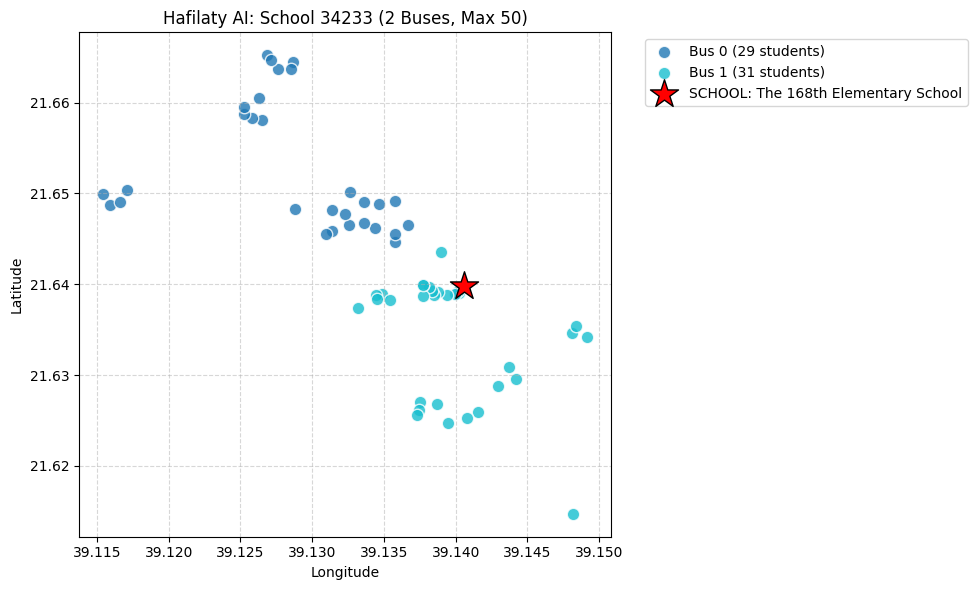

--- Processing School ID: 32438 ---
Saved: Hafilaty_School_32438_Results.csv


/var/folders/0t/jq8z2t1d4pl7fwtlvp10jz2r0000gn/T/ipykernel_70765/134923541.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', n_buses)


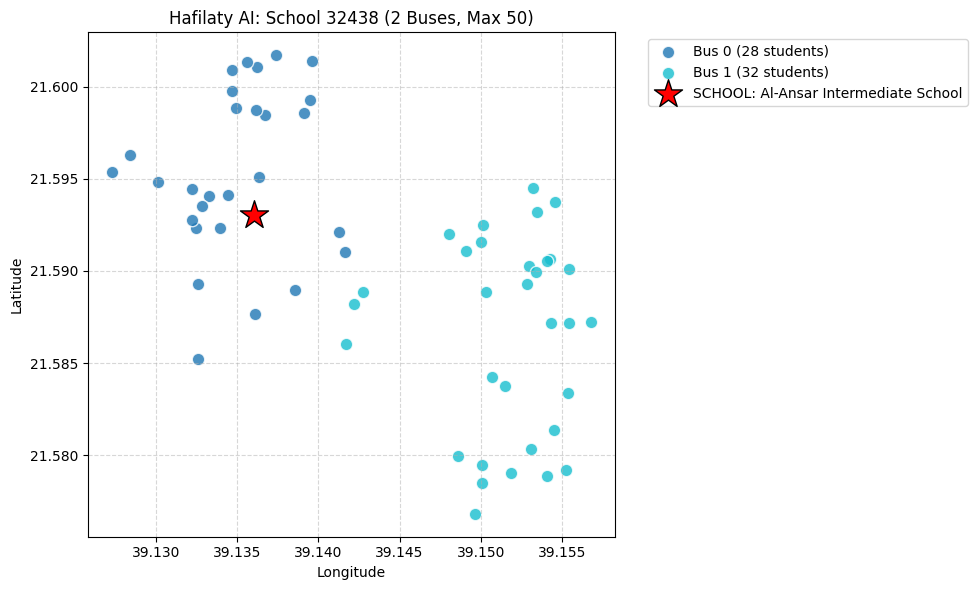


Success! All schools have been processed individually.


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# 1. LOAD DATA
# We load both the 'Students' and 'Schools' sheets
file_path = "STUDENTDATASET.xlsx"
df_students = pd.read_excel(file_path, sheet_name='Students')
df_schools = pd.read_excel(file_path, sheet_name='Schools')

# Clean up column names (removes hidden spaces and fixes typos like 'Longtitude')
df_schools.columns = df_schools.columns.str.strip()
if 'Longtitude' in df_schools.columns:
    df_schools.rename(columns={'Longtitude': 'Longitude'}, inplace=True)
if 'Latitude ' in df_schools.columns:
    df_schools.rename(columns={'Latitude ': 'Latitude'}, inplace=True)

# Define column names for easy use
LAT = 'Latitude'
LON = 'Longitude'
STUDENT_SCHOOL_ID = 'SchoolID'   # Column in Students sheet
SCHOOL_REF_ID = 'School ID'     # Column in Schools sheet

# --- CUSTOM CONFIGURATION ---
# Change these values to experiment with different bus numbers and capacities!
# Format: { SchoolID: (number_of_buses, capacity_per_bus) }
manual_config = {
    34233: (2, 50),  # School 34233: 3 buses, max 20 students each
    32438: (2, 50)   # School 32438: 4 buses, max 25 students each
}

def run_capacitated_clustering(student_df, school_id, n_clusters, bus_capacity):
    # Filter for specific school
    school_students = student_df[student_df[STUDENT_SCHOOL_ID] == school_id].copy()
    
    if school_students.empty:
        print(f"No students found for School ID {school_id}")
        return school_students

    coords = school_students[[LAT, LON]].values
    
    # AI TRAINING: K-Means (Initial grouping)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    school_students['Assigned_Bus_ID'] = kmeans.fit_predict(coords)
    centroids = kmeans.cluster_centers_
    
    # REFINEMENT: The Balancing Loop (Ensures no bus exceeds capacity)
    while True:
        counts = school_students['Assigned_Bus_ID'].value_counts()
        overloaded = counts[counts > bus_capacity].index.tolist()
        underloaded = counts[counts < bus_capacity].index.tolist()
        
        # Stop if no bus is overloaded OR if there are no underloaded buses to move students to
        if not overloaded or not underloaded:
            break
            
        for bus_id in overloaded:
            # Find students currently in this full bus
            bus_indices = school_students[school_students['Assigned_Bus_ID'] == bus_id].index
            # Calculate how far each student is from the center of this bus
            distances = cdist(school_students.loc[bus_indices, [LAT, LON]], [centroids[bus_id]]).flatten()
            # Pick the student furthest away to move
            furthest_student_idx = bus_indices[np.argmax(distances)]

            # Find which "underloaded" bus is closest to this student
            student_loc = school_students.loc[[furthest_student_idx], [LAT, LON]]
            dist_to_others = cdist(student_loc, [centroids[b] for b in underloaded]).flatten()
            new_bus_id = underloaded[np.argmin(dist_to_others)]
            
            # Reassign student
            school_students.at[furthest_student_idx, 'Assigned_Bus_ID'] = new_bus_id
            
    return school_students

# 2. EXECUTE, SAVE, AND PLOT
unique_schools = df_students[STUDENT_SCHOOL_ID].unique()

for sid in unique_schools:
    # Get your custom settings (defaults to 2 buses and 30 capacity if not in manual_config)
    n_buses, capacity = manual_config.get(sid, (2, 30))
    
    print(f"--- Processing School ID: {sid} ---")
    
    # Run the clustering logic
    school_results = run_capacitated_clustering(df_students, sid, n_buses, capacity)
    
    # Save a unique CSV for this school
    csv_name = f'Hafilaty_School_{sid}_Results.csv'
    school_results.to_csv(csv_name, index=False)
    print(f"Saved: {csv_name}")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Automatically pick distinct colors for each bus
    color_map = plt.cm.get_cmap('tab10', n_buses) 
    
    # Plot Students colored by their assigned bus
    for i, bus in enumerate(sorted(school_results['Assigned_Bus_ID'].unique())):
        bus_data = school_results[school_results['Assigned_Bus_ID'] == bus]
        plt.scatter(bus_data[LON], bus_data[LAT], 
                    color=color_map(i), 
                    label=f'Bus {bus} ({len(bus_data)} students)',
                    edgecolors='white', s=80, alpha=0.8)

    # Plot the School Location (The Red Star)
    school_info = df_schools[df_schools[SCHOOL_REF_ID] == sid]
    if not school_info.empty:
        s_lat = school_info.iloc[0][LAT]
        s_lon = school_info.iloc[0][LON]
        s_name = school_info.iloc[0]['School Name']
        plt.scatter(s_lon, s_lat, color='red', marker='*', s=450, 
                    label=f'SCHOOL: {s_name}', edgecolors='black', zorder=5)

    plt.title(f'Hafilaty AI: School {sid} ({n_buses} Buses, Max {capacity})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

print("\nSuccess! All schools have been processed individually.")